<h2><b>Main task analysis - excluding outliers</b></h2>
<p>Takes the summary table from the task analysis and tests H1a - <b>regressive errors are reduced and perseverative errors are increased in disgust learning</b></p>
<p>Exactly the same as the analyses done before but excluding outliers this time </p>
<p> Includes:</p>
<li>Hypothesis testing
<li>Model assumption tests 
<li>Adding covariates and random effects --> random intercepts for fractals and videos used in the task (feedback_randint) and by-participant random slopes; age, sex and working memory covariates
<li>Adding video rating scores
<li>Bayesian t-tests to assess strength of any null findings
<li>Follow-up, win-stay/lose-shift analyses

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import jsonlines
from functools import reduce
import statistics
import scipy.stats
import seaborn as sns
import math
import os
import json
import ast
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pingouin as pg
import warnings
from scipy.stats import ttest_rel
#from statannotations.Annotator import Annotator
from scipy.stats import skew
from statsmodels.stats.diagnostic import het_white
from sklearn.preprocessing import PowerTransformer
import statannot
from scipy.stats import ttest_ind
import itertools

from dataclean_func import *
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.copy_on_write = True

In [2]:
task_summary=pd.read_csv('csvs/dem_vids_task_excluded.csv')

<h2><b>Exclude outliers from the dataframe</b></h2>
<p>Outliers defined as >1.5 IQR below LQ or above UQ

In [3]:
#create outliers df --> removing those >1.5 IQRs above or below UQ and LQ
key_outcomes=['percentage_correct', 'mean_perseverative_er', 'mean_regressive_er', 'median_till_correct', 'win_stay', 'lose_shift']
for col in key_outcomes:
    task_summary=replace_outliers_with_nan(task_summary, col)

task_summary.to_csv('csvs/sensitivity_df.csv')
#check for outliers - this dataframe only has one outlier in the mean regressive error outcome
task_summary[task_summary.isna().any(axis=1)]

,Unnamed: 0,percentage_correct,mean_perseverative_er,mean_regressive_er,median_till_correct,mean_till_correct,win_stay,lose_shift,timed_out,block_no,...,unspecified,digit_span,prolific_age,prolific_sex,prolific_MH,time taken,self_report_gender,self_report_assigned-at-birth,self_report_age,aligns
0,0,0.716418,1.142857,0.428571,8.0,8.428571,0.951220,0.520000,0,1.0,...,0,8.0,61,Female,No,43.616667,Female,Yes,61,True
1,1,0.875000,0.000000,0.285714,6.0,6.142857,1.000000,0.733333,0,2.0,...,0,8.0,61,Female,No,43.616667,Female,Yes,61,True
2,2,0.757143,0.714286,0.857143,10.0,9.285714,1.000000,0.739130,0,3.0,...,0,8.0,61,Female,No,43.616667,Female,Yes,61,True
3,3,0.753086,0.285714,1.714286,12.0,10.857143,0.947368,0.782609,0,2.0,...,0,6.0,52,Male,No,40.283333,Male,Yes,52,True
4,4,0.634615,1.000000,3.142857,13.0,13.428571,0.937500,0.641026,0,1.0,...,0,6.0,52,Male,No,40.283333,Male,Yes,52,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1013,1205,0.746269,0.571429,0.714286,7.0,8.714286,0.947368,0.500000,0,1.0,...,0,7.0,46,Male,No,41.100000,Male,Yes,46,True
1016,1208,0.535000,1.571429,NaN,17.0,25.000000,0.669811,0.483871,1,3.0,...,0,7.0,47,Female,Yes,95.150000,Female,Yes,47,True
1017,1212,0.723577,0.000000,4.000000,12.0,16.714286,0.862500,0.738095,0,3.0,...,0,9.0,64,Male,No,50.083333,Male,Yes,64,True
1018,1213,0.683333,0.714286,3.571429,13.0,15.285714,0.942029,0.780000,0,1.0,...,0,9.0,64,Male,No,50.083333,Male,Yes,64,True


<h2><b>Main hypothesis tests</b></h2>
<p>Testing whether there are differences in perseverative and regressive errors across block type </p>
<p>Models to run: </p>
<li> 1) 'mean_perseverative_er ~ block_type'
<li> 2) 'mean_regressive_er ~ block_type'

<h4><b> MODEL 1: PERSEVERATIVE ERRORS </b></h4>

<b>Firstly - check the outcome for skewness<b>

Perseverative error skew: 0.9439083554848277


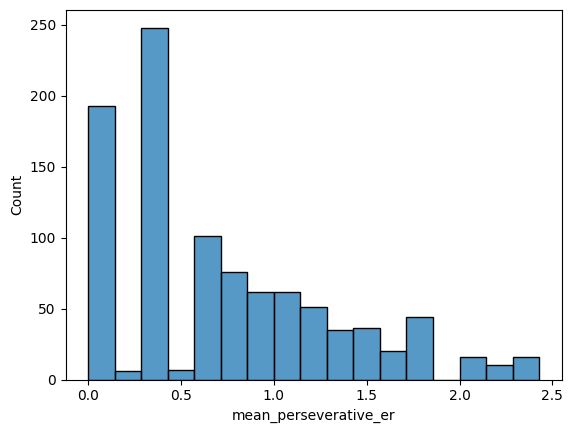

In [4]:
sns.histplot(data=task_summary, x="mean_perseverative_er") 
print('Perseverative error skew: '+str(skew(task_summary.mean_perseverative_er.dropna())))
#if skew isn't greater than 0.5 or less than -0.5 then nothing needs to be done
    #in this case, the skew is smaller than when there were outliers, but is still significant

Given that the distribution was skewed, we must perform a transformation

<Axes: xlabel='perseverative_er_transformed', ylabel='Count'>

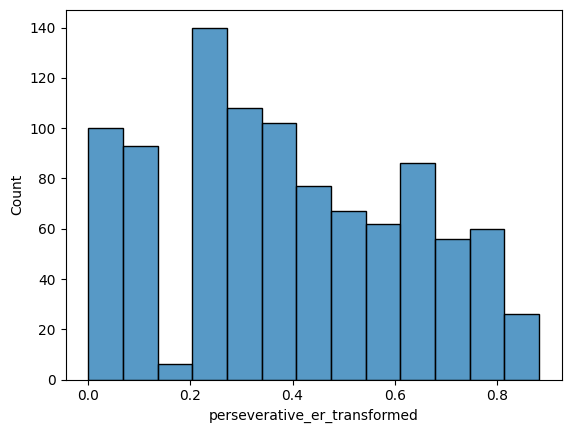

In [5]:
#All further analyses will be done on this transformed variable
pt=PowerTransformer(method='yeo-johnson', standardize=False)
skl_yeojohnson=pt.fit(pd.DataFrame(task_summary.mean_perseverative_er))
skl_yeojohnson=pt.transform(pd.DataFrame(task_summary.mean_perseverative_er))
task_summary['perseverative_er_transformed'] = pt.transform(pd.DataFrame(task_summary.mean_perseverative_er))
sns.histplot(data=task_summary['perseverative_er_transformed'])

<b>Next, identify the best fitting hypothesis testing model</b>
<p>Will test the fit of models with different random and fixed effects before determining which model to use for hypothesis testing:

In [6]:
data=task_summary.reset_index()

formula = 'perseverative_er_transformed ~ block_type'

basic_model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)

Test which random effects to include - models which didn't converge are commented out

   basic_model      feedback_andint     fractals_randint  \
0   -56.598502  CONVERGENCE WARNING  CONVERGENCE WARNING   

  feedback_fractals_randint  randslope feedback_randint_randslope  \
0              NOT CONVERGE -26.919263        CONVERGENCE WARNING   

  feedback_fractals_randint_randslope  
0                        NOT CONVERGE  


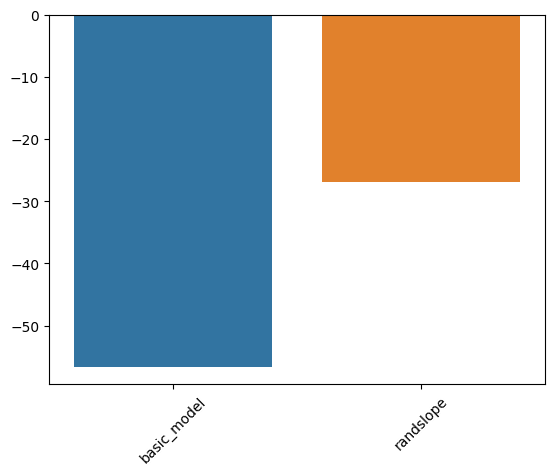

In [12]:
#test which random effects to include
#feedback_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
#fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'fractals': '0+fractals'}).fit(reml=False)
#feedback_fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={"feedback_details": "0 + feedback_details", "fractals": "0 + fractals"}).fit(reml=False)
        #had to comment out because it does not converge and errors out

randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~block_type').fit(reml=False)
#feedback_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}, re_formula='~block_type').fit(reml=False)
#feedback_fractals_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details', "fractals": "0 + fractals"}, re_formula='~block_type').fit(reml=False)


bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'feedback_andint': ['CONVERGENCE WARNING'], 
                    'fractals_randint': ['CONVERGENCE WARNING'],
                    'feedback_fractals_randint': ['NOT CONVERGE'], ##added manually
                    'randslope': [randslope.bic],
                    'feedback_randint_randslope':['CONVERGENCE WARNING'],
                    'feedback_fractals_randint_randslope': ['NOT CONVERGE']})
sns.barplot(bic)
plt.xticks(rotation=45) 
print(bic) ##in this case, basic model is the best

Test which covariates to add

   no_covariate  sex_covariate  age_covariate  digit_span_covariate  \
0    -56.598502     -50.407015     -52.732414            -50.606595   

   sex_age_covariate  sex_digit_span_covariate  digit_span_age_covariate  \
0         -46.612217                -44.639112                -46.318338   

   sex_age_digit_span_covariate  
0                    -40.366319  


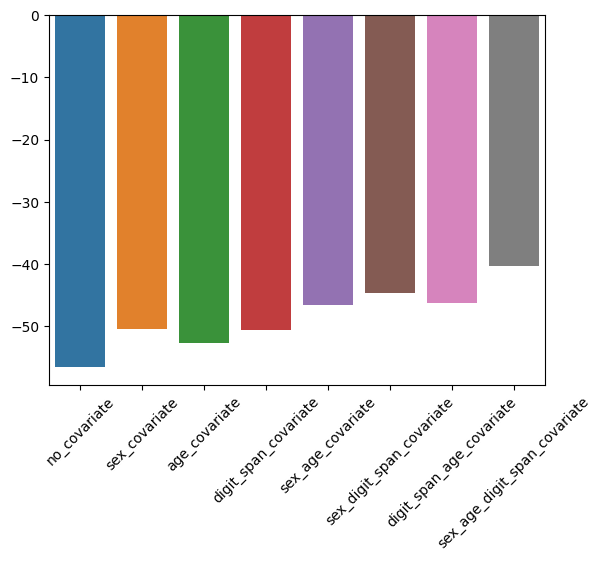

In [13]:
##test which covariates to add -- Using the random effects which were best above (basic model in this case)
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+prolific_sex'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
digit_span_covariate=smf.mixedlm(formula+str('+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
digit_span_age_covariate=smf.mixedlm(formula+str('+digit_span+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'digit_span_covariate': [digit_span_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic],
                    'sex_digit_span_covariate': [sex_digit_span_covariate.bic],
                    'digit_span_age_covariate': [digit_span_age_covariate.bic],
                    'sex_age_digit_span_covariate': [sex_age_digit_span_covariate.bic]})
sns.barplot(bic)
plt.xticks(rotation=45) 
print(bic) ##in this case, nocovariate is the best

<b>Now use that best fitting model for hypothesis testing </b>

In [14]:
#Hypothesis test using this model (and if no covariate model hadn't won - would run this too)
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
==========================================================================
Model:            MixedLM Dependent Variable: perseverative_er_transformed
No. Observations: 983     Method:             ML                          
No. Groups:       339     Scale:              0.0425                      
Min. group size:  1       Log-Likelihood:     45.5258                     
Max. group size:  3       Converged:          Yes                         
Mean group size:  2.9                                                     
----------------------------------------------------------------------------
                        Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
----------------------------------------------------------------------------
Intercept                0.403      0.013   30.442   0.000    0.377    0.429
block_type[T.Fear]      -0.005      0.016   -0.307   0.759   -0.037    0.027
block_type[T.Points]    -0.010      0.016   -0.596   0.551   -0.041    0.022
Group Var                0.014      0.013                                   
==========================================================================

"""

<b>Test the assumptions of the final model</b> 

In [15]:
#chosen model
results=no_covariate

#shapiro-Wilk test of normality of residuals
labels = ["Statistic", "p-value"]
norm_res = stats.shapiro(results.resid)

for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)
    ##if test is significant then the assumption is violated

##homoskedasticity of variance - commented out as produces an error (and it is irrelevant as the model as failed the other assumptions test)
#White Lagrange Multiplier Test for Heteroscedasticity
#het_white_res = het_white(results.resid, results.model.exog)

#labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]

#for key, val in dict(zip(labels, het_white_res)).items():
    #print(key, val)
    ##again, only violated if you get a significant p value

Statistic 0.9901267071073535
p-value 3.6068368922220437e-06


In [ ]:
# the assumptions are violated 
# we will need to test the hypothesis using a generalized mixed effects model
# this is done using R so is in a different notebook:
    #perseverative_ers_sensitivity.ipynb notebook (in generalized mixed effects model)

<b>Compute a Bayes factor to see strength of the null</b>
<li>As there is no difference between fear and disgust in the generalized model, we will compute a Bayes factor to determine the strength of that null.

In [16]:
##create a function to do this using the pinguouin package
        #NB for simplicity just doing pair-wise t-tests for key conditions
        #has been updated since stage one to make more streamline/understandable - outputs are the same as before
def bayes_factor(df, dependent_var, condition_1_name, condition_2_name):
    df=df[(df.block_type==condition_1_name)| (df.block_type==condition_2_name)][[dependent_var, 'block_type', 'participant_no']]
    df.dropna(inplace=True)
    df=df.pivot(index='participant_no', columns='block_type', values=dependent_var).reset_index()
    ttest=pg.ttest(df[condition_1_name], df[condition_2_name], paired=True)
    bf_null=1/float(ttest.BF10)
    return bf_null

In [17]:
bayes_factor(task_summary, 'perseverative_er_transformed', 'Fear', 'Disgust')

13.88888888888889

In [18]:
bayes_factor(task_summary, 'perseverative_er_transformed', 'Points', 'Disgust')

12.658227848101266

In [19]:
bayes_factor(task_summary, 'perseverative_er_transformed', 'Points', 'Fear')

15.15151515151515

<h4><b> MODEL 2: REGRESSIVE ERRORS </b></h4>
<p> Same again but with regressive rather than perseverative errors</p>

<b>Firstly - check the outcome for skewness</b>

Regressive error skew: 1.1057309176558778


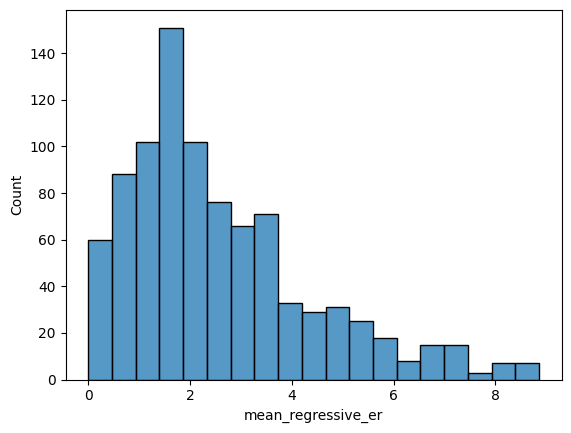

In [20]:
##Model assumptions - skew of distribution
    #data was created to be a skewed distribution - so skew value >0.5
sns.histplot(data=task_summary, x="mean_regressive_er") 
print('Regressive error skew: '+str(skew(task_summary.mean_regressive_er,  nan_policy='omit')))

Given that the distribution was skewed, must perform a transformation

<Axes: xlabel='regressive_er_transformed', ylabel='Count'>

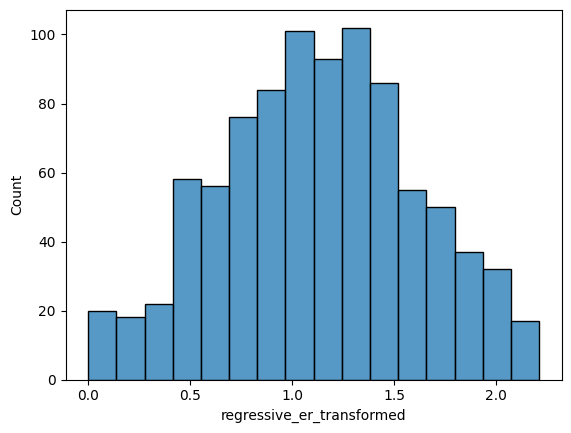

In [21]:
#All further analyses will be done on this transformed variable
pt=PowerTransformer(method='yeo-johnson', standardize=False)
skl_yeojohnson=pt.fit(pd.DataFrame(task_summary.mean_regressive_er))
skl_yeojohnson=pt.transform(pd.DataFrame(task_summary.mean_regressive_er))
task_summary['regressive_er_transformed'] = pt.transform(pd.DataFrame(task_summary.mean_regressive_er))
sns.histplot(data=task_summary['regressive_er_transformed'])

<b>Next, identify the best fitting hypothesis testing model</b>
<p>Will test the fit of models with different random and fixed effects before determining which model to use for hypothesis testing:

In [22]:
data=task_summary.reset_index()

formula = 'regressive_er_transformed ~ block_type'

basic_model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)

Test which random effects to include - models which didn't converge are commented out

   basic_model      feedback_andint     fractals_randint  \
0  1147.738017  CONVERGENCE WARNING  CONVERGENCE WARNING   

  feedback_fractals_randint    randslope  feedback_randint_randslope  \
0             NOT CONVERGED  1173.506853                 1180.316999   

  feedback_fractals_randint_randslope  
0                       NOT CONVERGED  


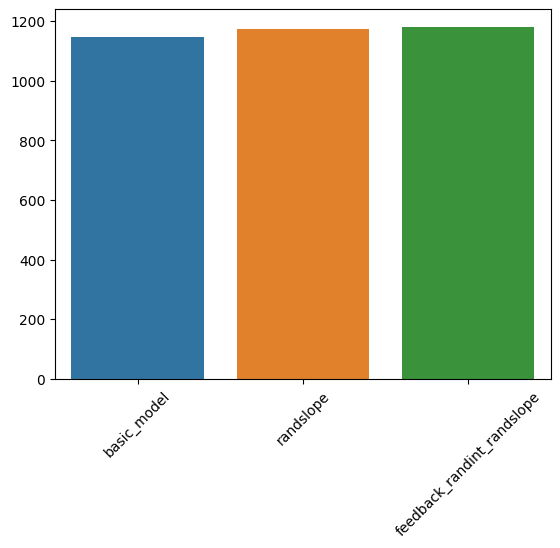

In [27]:
#test which random effects to include
#feedback_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
#fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'fractals': '0+fractals'}).fit(reml=False)
#feedback_fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={"feedback_details": "0 + feedback_details", "fractals": "0 + fractals"}).fit(reml=False)
        #had to comment out because it does not converge and errors out

randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~block_type').fit(reml=False)
feedback_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}, re_formula='~block_type').fit(reml=False)
#feedback_fractals_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details', "fractals": "0 + fractals"}, re_formula='~block_type').fit(reml=False)
       

bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'feedback_andint': ['CONVERGENCE WARNING'], 
                    'fractals_randint': ['CONVERGENCE WARNING'],
                    'feedback_fractals_randint': ['NOT CONVERGED'],
                    'randslope': [randslope.bic],
                    'feedback_randint_randslope':[feedback_randint_randslope.bic],
                    'feedback_fractals_randint_randslope': ['NOT CONVERGED']})##added manually
sns.barplot(bic)
plt.xticks(rotation=45) 
print(bic) ##in this case, basic model is the best

Test which covariates to add

   no_covariate  digit_span_covariate  sex_covariate  age_covariate  \
0   1147.738017           1152.475186    1153.013855    1154.548158   

   sex_digit_span_covariate  digit_span_age_covariate  sex_age_covariate  \
0               1158.136926               1159.249442        1159.822608   

   sex_age_digit_span_covariate  
0                   1164.905545  


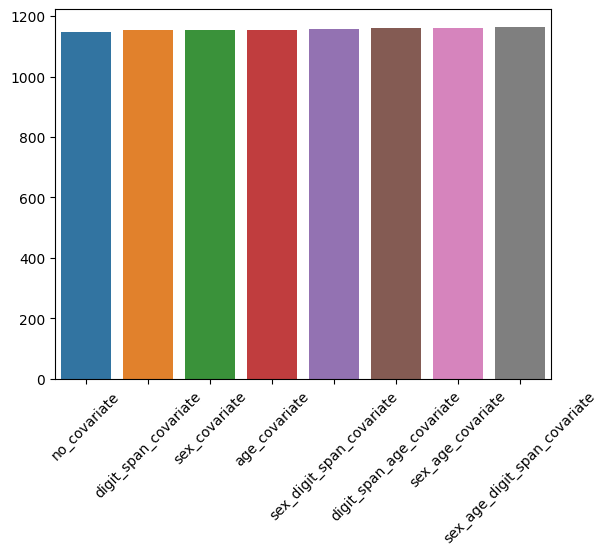

In [28]:
##test which covariates to add -- Using the random effects which were best above (basic model in this case)
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+prolific_sex'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
digit_span_covariate=smf.mixedlm(formula+str('+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
digit_span_age_covariate=smf.mixedlm(formula+str('+digit_span+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'digit_span_covariate': [digit_span_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic],
                    'sex_digit_span_covariate': [sex_digit_span_covariate.bic],
                    'digit_span_age_covariate': [digit_span_age_covariate.bic],
                    'sex_age_digit_span_covariate': [sex_age_digit_span_covariate.bic]})
plt.xticks(rotation=45)
sns.barplot(bic.sort_values(by=0, axis=1))
print(bic.sort_values(by=0, axis=1)) ##in this case, digit-span is the best

<b>Now use that best fitting model for hypothesis testing </b>

In [29]:
#no covariate summary for comparison
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
=======================================================================
Model:            MixedLM Dependent Variable: regressive_er_transformed
No. Observations: 907     Method:             ML                       
No. Groups:       327     Scale:              0.1368                   
Min. group size:  1       Log-Likelihood:     -556.8437                
Max. group size:  3       Converged:          Yes                      
Mean group size:  2.8                                                  
------------------------------------------------------------------------
                         Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------------------
Intercept                 1.150     0.027  42.163  0.000   1.096   1.203
block_type[T.Fear]       -0.002     0.030  -0.067  0.946  -0.062   0.057
block_type[T.Points]     -0.001     0.030  -0.035  0.972  -0.060   0.058
Group Var                 0.093     0.039                               
=======================================================================

"""

<b>Test the assumptions of this final model</b>

In [30]:
#chosen model
results=no_covariate

#shapiro-Wilk test of normality of residuals
labels = ["Statistic", "p-value"]
norm_res = stats.shapiro(results.resid)

for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)
    ##if test is significant then the assumption is violated
        #is significant here

##homoskedasticity of variance 
#White Lagrange Multiplier Test for Heteroscedasticity
het_white_res = het_white(results.resid, results.model.exog)

labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]

for key, val in dict(zip(labels, het_white_res)).items():
    print(key, val)
    ##again, only violated if you get a significant p value

Statistic 0.9988694126723006
p-value 0.8539183639658268
LM Statistic 3.7851740201083066
LM-Test p-value 0.1506814896455357
F-Statistic 1.89423225557972
F-Test p-value 0.1510303973629437


In [ ]:
# Assumptions are not violated - so results are valid

<b>Compute a Bayes factor to see strength of the null</b>
<li>As there is no effect of feedback type in the generalized model, we will compute Bayes factors to determine the strength of that null.

In [31]:
print(bayes_factor(task_summary, 'regressive_er_transformed', 'Disgust', 'Fear'))

15.15151515151515


In [32]:
print(bayes_factor(task_summary, 'regressive_er_transformed', 'Disgust', 'Points'))

15.15151515151515


In [ ]:
##NB it looks suspicious that the BFs are the same for these two different tests
#but the values have been checked and it is the product of both tests having
# a very small effect size

In [77]:
print(bayes_factor(task_summary, 'regressive_er_transformed', 'Fear', 'Points'))

14.492753623188404


<h2><b>Adding video ratings</b></h2>
<p>As specified in the analysis plan, we will test whether this result is modified by adding video ratings: </p>
<p>=models 3 and 4 in the analysis plan
<li>As there is a difference in valence and arousal across fear and disgusting videos: add these difference as a covariate (fear(T1)-disgust(T1) for valence AND arousal)
<li>As there is a difference in habituation between fear and disgusting videos: add this difference in habituation as a covariate (Fear(T1-T2) - Disgust(T1-T2))

<h4><b> MODEL 3: PERSEVERATIVE ERRORS W VIDEO RATINGS </b></h4>

<b>Firstly, identify the best fitting hypothesis testing model</b>
<p>Will test the fit of models with different random and fixed effects before determining which model to use for hypothesis testing:

In [33]:
data=task_summary.reset_index()

formula = 'perseverative_er_transformed ~ block_type + valence_diff + arousal_diff + valence_habdiff'

basic_model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)

Test which random effects to include - models which didn't converge are commented out

   basic_model      feedback_andint     fractals_randint  \
0   -39.705593  CONVERGENCE WARNING  CONVERGENCE WARNING   

   feedback_fractals_randint  randslope feedback_randint_randslope  \
0                  17.887416    -9.8788        CONVERGENCE WARNING   

  feedback_fractals_randint_randslope  
0                 CONVERGENCE WARNING  


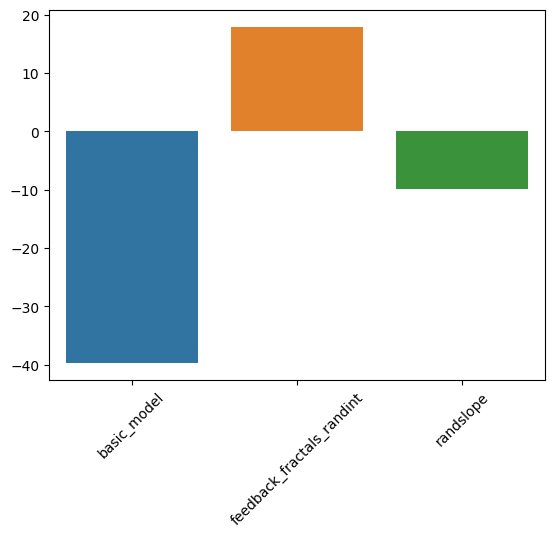

In [38]:
#test which random effects to include
#feedback_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
#fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'fractals': '0+fractals'}).fit(reml=False)
feedback_fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={"feedback_details": "0 + feedback_details", "fractals": "0 + fractals"}).fit(reml=False)
        
randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~block_type').fit(reml=False)
#feedback_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}, re_formula='~block_type').fit(reml=False)
#feedback_fractals_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details', "fractals": "0 + fractals"}, re_formula='~block_type').fit(reml=False)
        #had to comment out because it does not converge and errors out

bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'feedback_andint': ['CONVERGENCE WARNING'], 
                    'fractals_randint': ['CONVERGENCE WARNING'],
                    'feedback_fractals_randint': [feedback_fractals_randint.bic], ##added manually
                    'randslope': [randslope.bic],
                    'feedback_randint_randslope':['CONVERGENCE WARNING'],
                    'feedback_fractals_randint_randslope': ['CONVERGENCE WARNING']})
sns.barplot(bic)
plt.xticks(rotation=45) 
print(bic) ##in this case, basic model is the best

Test which covariates to add

   no_covariate  age_covariate  digit_span_covariate  sex_covariate  \
0    -39.705593     -35.039842            -33.770075     -33.483341   

   sex_age_covariate  digit_span_age_covariate  sex_digit_span_covariate  \
0         -28.883135                -28.733999                -27.778156   

   sex_age_digit_span_covariate  
0                    -22.761748  


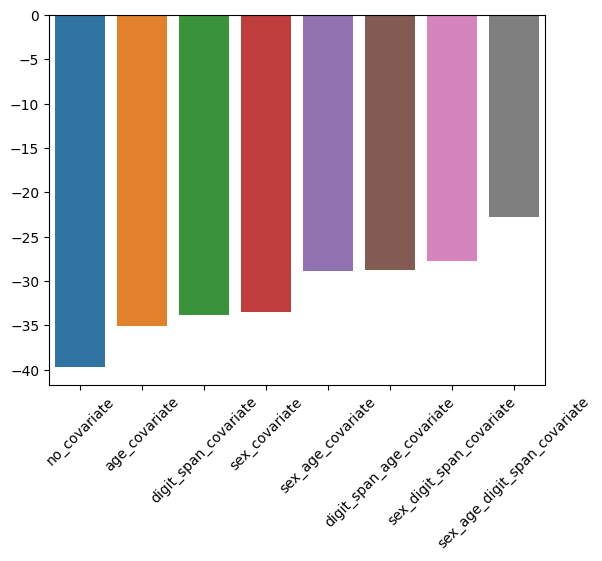

In [39]:
##test which covariates to add -- Using the random effects which were best above (basic model in this case)
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+prolific_sex'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
digit_span_covariate=smf.mixedlm(formula+str('+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
digit_span_age_covariate=smf.mixedlm(formula+str('+digit_span+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'digit_span_covariate': [digit_span_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic],
                    'sex_digit_span_covariate': [sex_digit_span_covariate.bic],
                    'digit_span_age_covariate': [digit_span_age_covariate.bic],
                    'sex_age_digit_span_covariate': [sex_age_digit_span_covariate.bic]})
plt.xticks(rotation=45) 
sns.barplot(bic.sort_values(by=0, axis=1))
print(bic.sort_values(by=0, axis=1)) ##in this case, the no covariate model is best

<b>Now use that best fitting model for hypothesis testing </b>

In [40]:
#no covariate model
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
==========================================================================
Model:            MixedLM Dependent Variable: perseverative_er_transformed
No. Observations: 983     Method:             ML                          
No. Groups:       339     Scale:              0.0425                      
Min. group size:  1       Log-Likelihood:     47.4152                     
Max. group size:  3       Converged:          Yes                         
Mean group size:  2.9                                                     
----------------------------------------------------------------------------
                        Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
----------------------------------------------------------------------------
Intercept                0.403      0.015   27.193   0.000    0.374    0.432
block_type[T.Fear]      -0.005      0.016   -0.299   0.765   -0.037    0.027
block_type[T.Points]    -0.010      0.016   -0.588   0.557   -0.041    0.022
valence_diff            -0.006      0.006   -0.979   0.328   -0.017    0.006
arousal_diff            -0.011      0.008   -1.464   0.143   -0.027    0.004
valence_habdiff          0.001      0.004    0.138   0.891   -0.008    0.009
Group Var                0.014      0.013                                   
==========================================================================

"""

<b>Test the assumptions of the final model</b> 

In [41]:
#chosen model
results=no_covariate

#shapiro-Wilk test of normality of residuals
labels = ["Statistic", "p-value"]
norm_res = stats.shapiro(results.resid)

for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)
    ##if test is significant then the assumption is violated
        #is significant here

##homoskedasticity of variance 
#White Lagrange Multiplier Test for Heteroscedasticity
het_white_res = het_white(results.resid, results.model.exog)

labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]

for key, val in dict(zip(labels, het_white_res)).items():
    print(key, val)
    ##again, only violated if you get a significant p value

Statistic 0.98989938998603
p-value 2.7648916440248064e-06
LM Statistic 17.172441766293716
LM-Test p-value 0.44274357497755573
F-Statistic 1.009278103358513
F-Test p-value 0.44500479410521304


In [ ]:
# the assumptions are violated 
# we will need to test the hypothesis using a generalized mixed effects model
# this is done using R so is in a different notebook:
    #perseverative_ers_wVideoRatings_sensitivity.ipynb notebook (in generalized mixed effects model)

<h4><b> MODEL 4: REGRESSIVE ERRORS W VIDEO RATINGS </b></h4>
<p> Same again but with regressive rather than perseverative errors</p>

<b>Firstly, identify the best fitting hypothesis testing model</b>
<p>Will test the fit of models with different random and fixed effects before determining which model to use for hypothesis testing:

In [42]:
formula = 'regressive_er_transformed ~ block_type + valence_diff + arousal_diff + valence_habdiff'

basic_model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)

Test which random effects to include - models which didn't converge are commented out

   basic_model      feedback_andint     fractals_randint  \
0   1167.37769  CONVERGENCE WARNING  CONVERGENCE WARNING   

  feedback_fractals_randint    randslope  feedback_randint_randslope  \
0       CONVERGENCE WARNING  1193.204714                 1200.014855   

  feedback_fractals_randint_randslope  
0                        NOT CONVERGE  


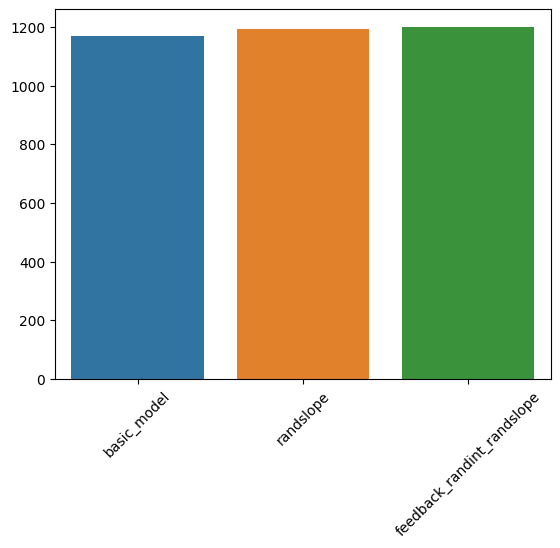

In [47]:
#test which random effects to include
#feedback_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
#fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'fractals': '0+fractals'}).fit(reml=False)
#feedback_fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={"feedback_details": "0 + feedback_details", "fractals": "0 + fractals"}).fit(reml=False)
        #had to comment out because it does not converge and errors out

randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~block_type').fit(reml=False)
feedback_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}, re_formula='~block_type').fit(reml=False)
#feedback_fractals_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details', "fractals": "0 + fractals"}, re_formula='~block_type').fit(reml=False)


bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'feedback_andint': ['CONVERGENCE WARNING'], 
                    'fractals_randint': ['CONVERGENCE WARNING'],
                    'feedback_fractals_randint': ['CONVERGENCE WARNING'], 
                    'randslope': [randslope.bic],
                    'feedback_randint_randslope':[feedback_randint_randslope.bic],
                    'feedback_fractals_randint_randslope': ['NOT CONVERGE']})
sns.barplot(bic)
plt.xticks(rotation=45) 
print(bic) ##in this case, basic model is the best
        #if two models have the same BIC we got for the simplest model (models are in order of simplicity)

Test which covariates to add

   no_covariate  digit_span_covariate  sex_covariate  age_covariate  \
0    1167.37769           1171.855218    1172.567288    1174.183086   

   sex_digit_span_covariate  digit_span_age_covariate  sex_age_covariate  \
0               1177.456157               1178.648932        1179.376555   

   sex_age_digit_span_covariate  
0                   1184.245072  


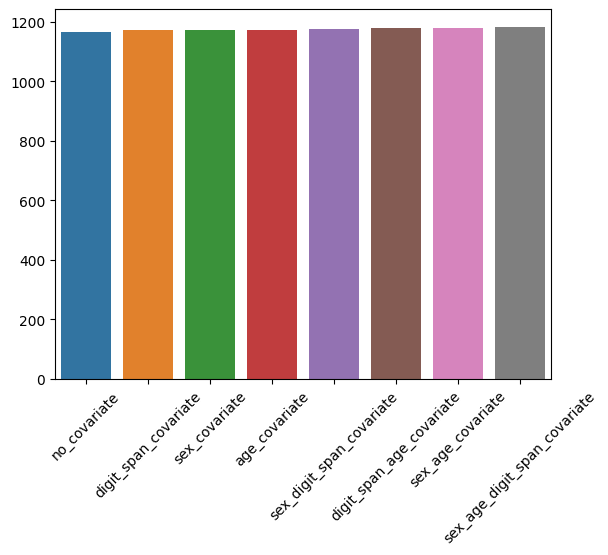

In [48]:
##test which covariates to add -- Using the random effects which were best above (basic model in this case)
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+prolific_sex'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
digit_span_covariate=smf.mixedlm(formula+str('+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
digit_span_age_covariate=smf.mixedlm(formula+str('+digit_span+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'digit_span_covariate': [digit_span_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic],
                    'sex_digit_span_covariate': [sex_digit_span_covariate.bic],
                    'digit_span_age_covariate': [digit_span_age_covariate.bic],
                    'sex_age_digit_span_covariate': [sex_age_digit_span_covariate.bic]})
plt.xticks(rotation=45) 
sns.barplot(bic.sort_values(by=0, axis=1))
print(bic.sort_values(by=0, axis=1)) ##in this case, DIGITSPAN covariate is best
    

<b>Now use that best fitting model for hypothesis testing </b>

In [49]:
#hypothesis test
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
=======================================================================
Model:            MixedLM Dependent Variable: regressive_er_transformed
No. Observations: 907     Method:             ML                       
No. Groups:       327     Scale:              0.1369                   
Min. group size:  1       Log-Likelihood:     -556.4483                
Max. group size:  3       Converged:          Yes                      
Mean group size:  2.8                                                  
------------------------------------------------------------------------
                         Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------------------
Intercept                 1.141     0.031  36.353  0.000   1.079   1.202
block_type[T.Fear]       -0.002     0.030  -0.078  0.938  -0.062   0.057
block_type[T.Points]     -0.001     0.030  -0.042  0.967  -0.061   0.058
valence_diff             -0.002     0.013  -0.153  0.878  -0.028   0.024
arousal_diff              0.016     0.018   0.874  0.382  -0.020   0.052
valence_habdiff           0.003     0.011   0.317  0.751  -0.017   0.024
Group Var                 0.093     0.039                               
=======================================================================

"""

<b>Test the assumptions of this final model</b>

In [50]:
#again checking assumptions
#chosen model
results=no_covariate

#shapiro-Wilk test of normality of residuals
labels = ["Statistic", "p-value"]
norm_res = stats.shapiro(results.resid)

for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)
    ##if test is significant then the assumption is violated
        #is significant here

##homoskedasticity of variance 
#White Lagrange Multiplier Test for Heteroscedasticity
het_white_res = het_white(results.resid, results.model.exog)

labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]

for key, val in dict(zip(labels, het_white_res)).items():
    print(key, val)
    ##again, only violated if you get a significant p value

Statistic 0.9988861183674403
p-value 0.8621665767375177
LM Statistic 13.350445493912634
LM-Test p-value 0.7124281619582463
F-Statistic 0.7812343930336054
F-Test p-value 0.7163175239908826


In [ ]:
#assumptions are not violated - so results are valid

<h2><b>Win-stay/lose-shift analyses</b></h2>
<p>This is only to be run if there are differences in regressive or perseverative errors across the block types (significant effects of block type in models 1 or 2)</p>
<p>The generalized mixed effect model (including outliers) showed differences in perseverative errors between disgust and points blocks, so these models are warranted (to unpick what is driving this difference)</p>
<br>
<p>Models to run: </p>
<li> 5) 'win_stay ~ block_type + any covariates that were significant in models 1 and 2'
<li> 6) 'lose_shift ~ block_type + any covariates that were significant in models 1 and 2'

<h4><b> MODEL 5: WIN-STAY </b></h4>

<b>Firstly - check the outcome for skewness<b>

Win-stay  skew: -1.1512521637523532


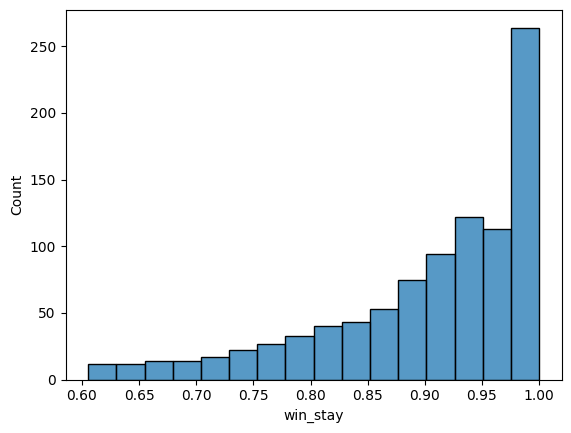

In [51]:
sns.histplot(data=task_summary, x="win_stay") 
print('Win-stay  skew: '+str(skew(task_summary.win_stay.dropna())))

Given that the distribution was skewed, we must perform a transformation

<Axes: xlabel='win_stay_transformed', ylabel='Count'>

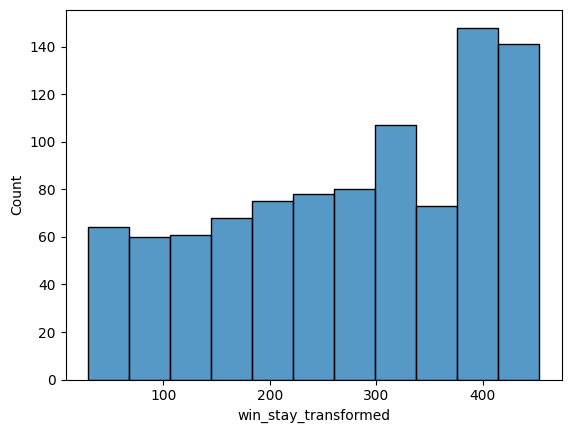

In [52]:
#All further analyses will be done on this transformed variable
pt=PowerTransformer(method='yeo-johnson', standardize=False)
skl_yeojohnson=pt.fit(pd.DataFrame(task_summary.win_stay))
skl_yeojohnson=pt.transform(pd.DataFrame(task_summary.win_stay))
task_summary['win_stay_transformed'] = pt.transform(pd.DataFrame(task_summary.win_stay))
sns.histplot(data=task_summary['win_stay_transformed'])

<b>Next, identify the best fitting hypothesis testing model</b>
<p>Will test the fit of models with different random and fixed effects before determining which model to use for hypothesis testing:

In [53]:
##most basic model
data=task_summary
formula = 'win_stay_transformed ~ block_type'
basic_model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)

Test which random effects to include - models which didn't converge are commented out. 

   basic_model     feedback_randint     fractals_randint  \
0  11728.03423  CONVERGENCE WARNING  CONVERGENCE WARNING   

   feedback_fractals_randint     randslope  feedback_randint_randslope  \
0               12004.796615  11757.948767                11764.810479   

   feedback_fractals_randint_randslope  
0                         11771.672198  


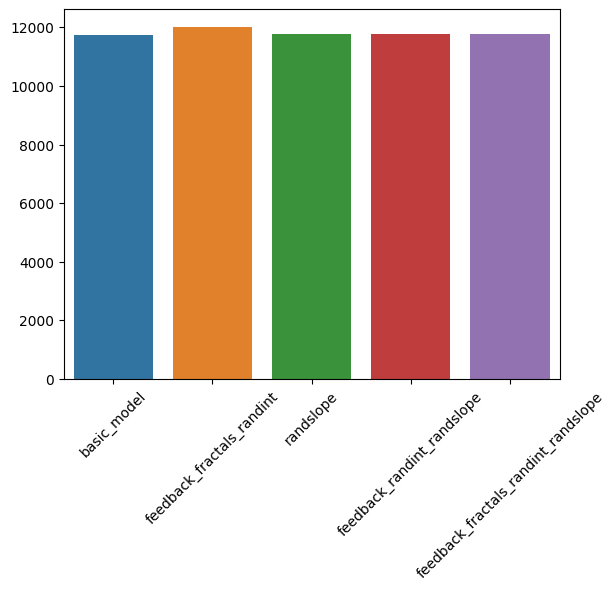

In [56]:
#test which random effects to include
#feedback_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
#fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'fractals': '0+fractals'}).fit(reml=False)
feedback_fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={"feedback_details": "0 + feedback_details", "fractals": "0 + fractals"}).fit(reml=False)
        #had to comment out because it does not converge and errors out

randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~block_type').fit(reml=False)
feedback_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}, re_formula='~block_type').fit(reml=False)
feedback_fractals_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details', "fractals": "0 + fractals"}, re_formula='~block_type').fit(reml=False)


bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'feedback_randint': ['CONVERGENCE WARNING'], 
                    'fractals_randint': ['CONVERGENCE WARNING'],
                    'feedback_fractals_randint': [feedback_fractals_randint.bic], 
                    'randslope': [randslope.bic],
                    'feedback_randint_randslope':[feedback_randint_randslope.bic],
                    'feedback_fractals_randint_randslope': [feedback_fractals_randint_randslope.bic]})
sns.barplot(bic)
plt.xticks(rotation=45) 
print(bic) ##in this case, it is the most basic model

Test which covariates to add

   age_covariate  no_covariate  sex_age_covariate  digit_span_age_covariate  \
0   11725.404058   11728.03423       11728.730583              11731.114853   

   sex_covariate  digit_span_covariate  sex_age_digit_span_covariate  \
0   11731.156237          11732.672305                  11734.866348   

   sex_digit_span_covariate  
0              11736.418628  


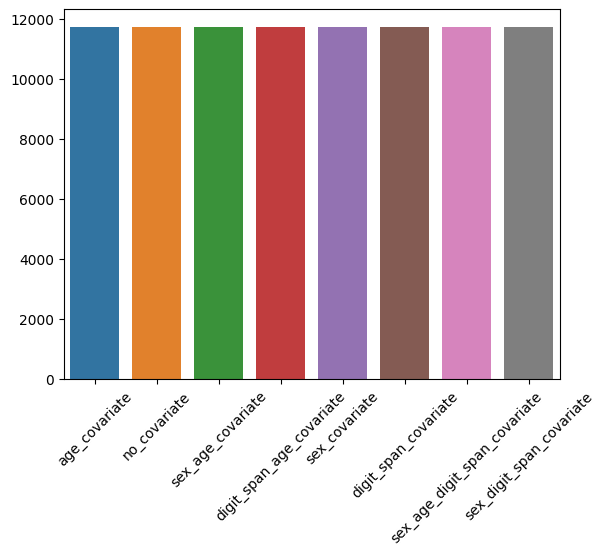

In [57]:
##test which covariates to add -- Using the random effects which were best above 
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+prolific_sex'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
digit_span_covariate=smf.mixedlm(formula+str('+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
digit_span_age_covariate=smf.mixedlm(formula+str('+digit_span+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'digit_span_covariate': [digit_span_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic],
                    'sex_digit_span_covariate': [sex_digit_span_covariate.bic],
                    'digit_span_age_covariate': [digit_span_age_covariate.bic],
                    'sex_age_digit_span_covariate': [sex_age_digit_span_covariate.bic]})
plt.xticks(rotation=45) 
sns.barplot(bic.sort_values(by=0, axis=1))
print(bic.sort_values(by=0, axis=1)) ##in this case, digitspan

<b>Now use that best fitting model for hypothesis testing </b>

In [58]:
#hypothesis test
age_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
===================================================================
Model:             MixedLM Dependent Variable: win_stay_transformed
No. Observations:  955     Method:             ML                  
No. Groups:        334     Scale:              6992.8863           
Min. group size:   1       Log-Likelihood:     -5842.1169          
Max. group size:   3       Converged:          Yes                 
Mean group size:   2.9                                             
-------------------------------------------------------------------
                      Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-------------------------------------------------------------------
Intercept             220.523   19.222 11.472 0.000 182.849 258.198
block_type[T.Fear]     -1.130    6.690 -0.169 0.866 -14.243  11.983
block_type[T.Points]   -5.629    6.673 -0.843 0.399 -18.708   7.450
prolific_age            1.231    0.397  3.098 0.002   0.452   2.009
Group Var            9276.049   13.870                             
===================================================================

"""

In [59]:
#hypothesis test without age covariate
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
===================================================================
Model:             MixedLM Dependent Variable: win_stay_transformed
No. Observations:  955     Method:             ML                  
No. Groups:        334     Scale:              7003.2210           
Min. group size:   1       Log-Likelihood:     -5846.8628          
Max. group size:   3       Converged:          Yes                 
Mean group size:   2.9                                             
-------------------------------------------------------------------
                      Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-------------------------------------------------------------------
Intercept             275.798    7.160 38.519 0.000 261.765 289.831
block_type[T.Fear]     -1.305    6.696 -0.195 0.845 -14.428  11.819
block_type[T.Points]   -5.676    6.679 -0.850 0.395 -18.766   7.414
Group Var            9579.353   14.266                             
===================================================================

"""

<b>Test the assumptions of this model</b>

In [60]:
#again checking assumptions

#chosen model
results=age_covariate

#shapiro-Wilk test of normality of residuals
labels = ["Statistic", "p-value"]
norm_res = stats.shapiro(results.resid)

for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)
    ##if test is significant then the assumption is violated
        #is significant here

##homoskedasticity of variance 
#White Lagrange Multiplier Test for Heteroscedasticity
het_white_res = het_white(results.resid, results.model.exog)

labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]

for key, val in dict(zip(labels, het_white_res)).items():
    print(key, val)
    ##again, only violated if you get a significant p value

Statistic 0.996929605796315
p-value 0.06302663951601054
LM Statistic 1.2916633127210986
LM-Test p-value 0.9721154055677161
F-Statistic 0.2139886960816659
F-Test p-value 0.9724366577776193


In [ ]:
##assumptions are NOT violated so results from the mixed effects model above stands

<b>Compute a Bayes factor to see strength of the null</b>
<li>As there is no effect of feedback-type in the generalized model, we will compute Bayes factors to determine the strength of that null.

In [61]:
bayes_factor(task_summary, 'win_stay_transformed', 'Fear', 'Disgust')

15.384615384615383

In [62]:
bayes_factor(task_summary, 'win_stay_transformed', 'Points', 'Disgust')

11.76470588235294

In [63]:
bayes_factor(task_summary, 'win_stay_transformed', 'Points', 'Fear')

11.363636363636365

<h4><b> MODEL 6: LOSE-SHIFT </b></h4>

Lose-shift has no outliers, so a sensitivity analysis is not necessary

In [64]:
###lose shift has no outliers - so a sensitivity analysis is not necessary
print("Number of lose-shift outliers: "+str(len(task_summary[task_summary.lose_shift.isna()])))

Number of lose-shift outliers: 0


<h2><b>Adding video ratings</b></h2>
<p>As specified in the analysis plan, we will test whether this result is modified by adding video ratings: </p>
<p>=models 7 and 8 in the analysis plan
<li>As there is a difference in valence and arousal across fear and disgusting videos: add these difference as a covariate (fear(T1)-disgust(T1) for valence AND arousal)
<li>As there is a difference in habituation between fear and disgusting videos: add this difference in habituation as a covariate (Fear(T1-T2) - Disgust(T1-T2))

<h4><b> MODEL 7: WIN-STAY W VIDEO RATINGS</b></h4>

<b>Firstly, identify the best fitting hypothesis testing model</b>
<p>Will test the fit of models with different random and fixed effects before determining which model to use for hypothesis testing:

In [65]:
data=task_summary.reset_index()

formula = 'win_stay_transformed ~ block_type + valence_diff + arousal_diff + valence_habdiff'

basic_model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)

Test which random effects to include - models which did not converge are commented out

    basic_model     feedback_randint     fractals_randint  \
0  11747.162169  CONVERGENCE WARNING  CONVERGENCE WARNING   

  feedback_fractals_randint     randslope  feedback_randint_randslope  \
0              NOT CONVERGE  11777.027624                11783.889335   

  feedback_fractals_randint_randslope  
0                        NOT CONVERGE  


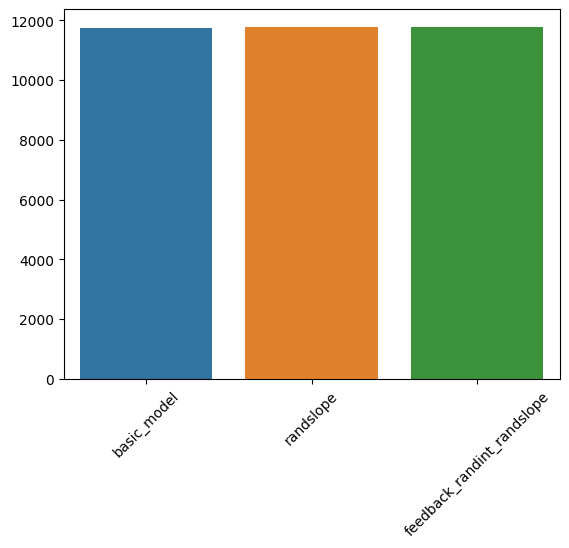

In [69]:
#test which random effects to include
#feedback_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
#fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'fractals': '0+fractals'}).fit(reml=False)
#feedback_fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={"feedback_details": "0 + feedback_details", "fractals": "0 + fractals"}).fit(reml=False)
        #had to comment out because it does not converge and errors out

randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~block_type').fit(reml=False)
feedback_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}, re_formula='~block_type').fit(reml=False)
#feedback_fractals_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details', "fractals": "0 + fractals"}, re_formula='~block_type').fit(reml=False)


bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'feedback_randint': ['CONVERGENCE WARNING'], 
                    'fractals_randint': ['CONVERGENCE WARNING'],
                    'feedback_fractals_randint': ['NOT CONVERGE'], ##added manually
                    'randslope': [randslope.bic],
                    'feedback_randint_randslope':[feedback_randint_randslope.bic],
                    'feedback_fractals_randint_randslope': ['NOT CONVERGE']})
sns.barplot(bic)
plt.xticks(rotation=45) 
print(bic) ##in this case, basic model is best

Test which covariates to add

   age_covariate  no_covariate  sex_age_covariate  sex_covariate  \
0   11744.905732  11747.162169       11748.000073   11750.029828   

   digit_span_age_covariate  digit_span_covariate  \
0              11750.268488          11751.383695   

   sex_age_digit_span_covariate  sex_digit_span_covariate  
0                   11753.85372              11754.938022  


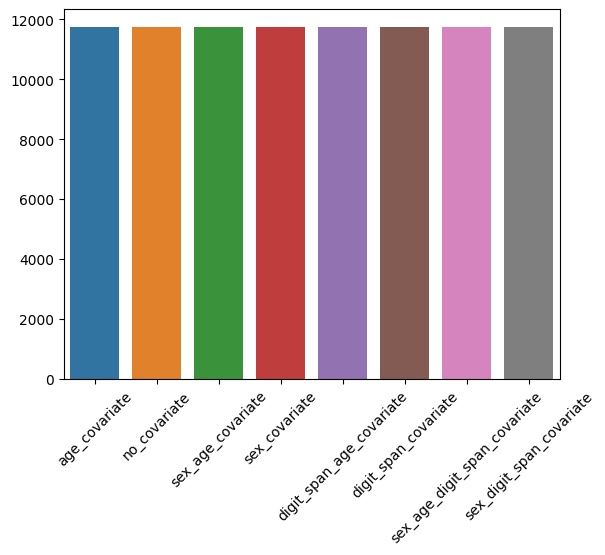

In [70]:
##test which covariates to add -- Using the random effects which were best above 
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+prolific_sex'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
digit_span_covariate=smf.mixedlm(formula+str('+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
digit_span_age_covariate=smf.mixedlm(formula+str('+digit_span+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'digit_span_covariate': [digit_span_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic],
                    'sex_digit_span_covariate': [sex_digit_span_covariate.bic],
                    'digit_span_age_covariate': [digit_span_age_covariate.bic],
                    'sex_age_digit_span_covariate': [sex_age_digit_span_covariate.bic]})
plt.xticks(rotation=45)
sns.barplot(bic.sort_values(by=0, axis=1))
print(bic.sort_values(by=0, axis=1)) ##in this case, digit span

<b>Now use the best fitting model for hypothesis testing </b>

In [71]:
#hypothesis test 
age_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
===================================================================
Model:             MixedLM Dependent Variable: win_stay_transformed
No. Observations:  955     Method:             ML                  
No. Groups:        334     Scale:              6993.6163           
Min. group size:   1       Log-Likelihood:     -5841.5752          
Max. group size:   3       Converged:          Yes                 
Mean group size:   2.9                                             
-------------------------------------------------------------------
                      Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-------------------------------------------------------------------
Intercept             225.724   19.916 11.334 0.000 186.690 264.758
block_type[T.Fear]     -1.065    6.691 -0.159 0.874 -14.179  12.050
block_type[T.Points]   -5.572    6.674 -0.835 0.404 -18.652   7.509
valence_diff            3.665    3.832  0.957 0.339  -3.845  11.175
arousal_diff           -2.674    5.169 -0.517 0.605 -12.805   7.458
valence_habdiff        -1.633    2.957 -0.552 0.581  -7.428   4.162
prolific_age            1.217    0.401  3.036 0.002   0.431   2.002
Group Var            9235.265   13.825                             
===================================================================

"""

In [72]:
#remove covariate
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
===================================================================
Model:             MixedLM Dependent Variable: win_stay_transformed
No. Observations:  955     Method:             ML                  
No. Groups:        334     Scale:              7002.9994           
Min. group size:   1       Log-Likelihood:     -5846.1342          
Max. group size:   3       Converged:          Yes                 
Mean group size:   2.9                                             
-------------------------------------------------------------------
                      Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-------------------------------------------------------------------
Intercept             280.540    8.438 33.249 0.000 264.003 297.078
block_type[T.Fear]     -1.246    6.696 -0.186 0.852 -14.370  11.878
block_type[T.Points]   -5.621    6.679 -0.842 0.400 -18.712   7.469
valence_diff            4.667    3.866  1.207 0.227  -2.910  12.243
arousal_diff           -1.314    5.215 -0.252 0.801 -11.535   8.907
valence_habdiff        -1.330    2.992 -0.445 0.657  -7.194   4.534
Group Var            9527.405   14.205                             
===================================================================

"""

<b>Test the assumptions of this model</b>

In [73]:
#again checking assumptions

#chose model
results=age_covariate

#shapiro-Wilk test of normality of residuals
labels = ["Statistic", "p-value"]
norm_res = stats.shapiro(results.resid)

for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)
    ##if test is significant then the assumption is violated
        #is significant here

##homoskedasticity of variance 
#White Lagrange Multiplier Test for Heteroscedasticity
het_white_res = het_white(results.resid, results.model.exog)

labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]

for key, val in dict(zip(labels, het_white_res)).items():
    print(key, val)
    ##again, only violated if you get a significant p value

Statistic 0.9968174179331105
p-value 0.0527714290007855
LM Statistic 16.189293421674396
LM-Test p-value 0.8811225232117103
F-Statistic 0.6682232272108647
F-Test p-value 0.8848727181148472


<h4><b> MODEL 8: LOSE-SHIFT W VIDEO RATINGS </b></h4>

Again, this doesn't need to be run as lose-shift has no outliers

In [74]:
###lose shift has no outliers - so a sensitivity analysis is not necessary
print("Number of lose-shift outliers: "+str(len(task_summary[task_summary.lose_shift.isna()])))

Number of lose-shift outliers: 0
